In [165]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from pytorch3d.io import load_obj, load_objs_as_meshes

torch.set_grad_enabled(False)

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

s = 1.8
dist = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


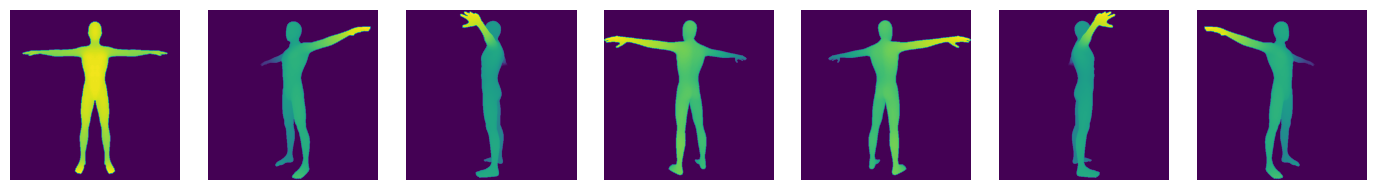

In [166]:
import numpy as np
from text3d2video.ipython_utils import display_ims
from text3d2video.utilities.camera_placement import turntable_extrinsics
from pytorch3d.renderer import FoVPerspectiveCameras

n_views = 7

angles = np.linspace(0, 360, n_views, endpoint=False)
R, T = turntable_extrinsics(angles=angles, dists=1)

cams = FoVPerspectiveCameras(R=R, T=T, device="cuda")
meshes = mesh.extend(len(cams))

depths = render_depth_map(meshes, cams)
display_ims(depths)

In [167]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texgen_pipeline import TexGenPipeline
from diffusers import DDIMScheduler

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(
    TexGenPipeline, sd_repo, controlnet_repo, scheduler_class=DDIMScheduler
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


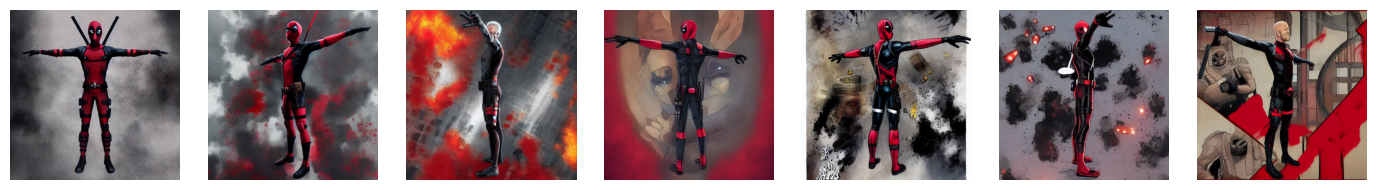

In [186]:
from text3d2video.pipelines.texgen_pipeline import TexGenConfig


prompt = "Deadpool"

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

config = TexGenConfig(
    num_inference_steps=10, guidance_scale=7.5, controlnet_conditioning_scale=1.0
)

images = pipe(
    prompt,
    meshes,
    cams,
    verts_uvs,
    faces_uvs,
    texgen_config=config,
    generator=generator,
)

display_ims(images)

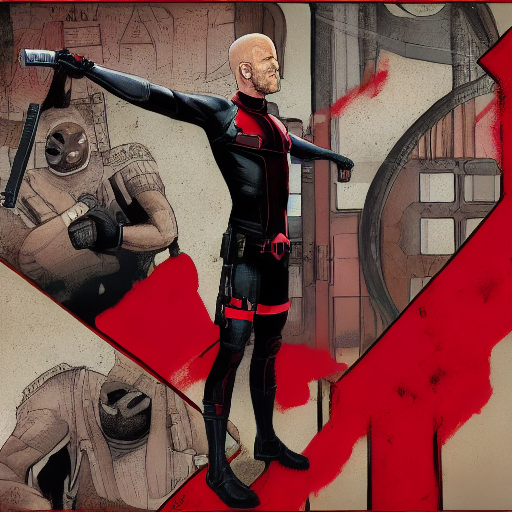

In [187]:
images[-1]